In [22]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# grab / parse data

In [55]:
directory = "midi/Piano"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = 1
instru = instrument.Piano()

notes = [[] for track in range(tracks)]
durations = [[] for track in range(tracks)]
for i, file in enumerate(os.listdir(directory)):
    midi_part = converter.parse(os.path.join(directory, file))
    # Parse the midi file by the notes/chords it contains
    for track in range(tracks):
        notes_to_parse = midi_part[track].flat.notesAndRests
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[track].append([str(elem.pitch)])
            elif isinstance(elem, chord.Chord):
                notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
            elif isinstance(elem, note.Rest):
                notes[track].append([elem.name])
            durations[track].append(elem.quarterLength)
        notes[track].append(["rest"])
        durations[track].append(1.0)
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track in range(tracks)]
np_notes = [np_notes[track].flatten() for track in range(tracks)]
notes_vocab = [[] for track in range(tracks)]
for track in range(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in range(tracks)]
for track in range(tracks):
    durations_vocab[track] = sorted(set(durations[track]))

for track in range(tracks):
    print(len(notes_vocab[track]), len(durations_vocab[track]), len(notes[track]))
print(notes_vocab, notes)
print(durations_vocab, durations)

Song Bach_2PartInv_No1_in_C_BWV772.mid Loaded
Song Bach_2PartInv_No8_in_F_BWV779.mid Loaded
Song dgjsbi3v.mid Loaded
Song firstmvm.mid Loaded
Song french4.mid Loaded
Song gigue.mid Loaded
Song gigue1.mid Loaded
Song jg_bps27.mid Loaded
Song jsb2pin1.mid Loaded
Song jsb2pin4.mid Loaded
Song jsb2pin8.mid Loaded
Song moonlite.mid Loaded
Song nf_be103.mid Loaded
Song presto.mid Loaded
Song secondmv.mid Loaded
Song sonat-1.mid Loaded
Song sonat-10.mid Loaded
Song sonat-2.mid Loaded
Song sonat-3.mid Loaded
Song sonat-4.mid Loaded
Song sonat-5.mid Loaded
Song sonat-6.mid Loaded
Song sonat-7.mid Loaded
Song sonat-8.mid Loaded
Song sonat-9.mid Loaded
Song thirdmvm.mid Loaded
Song zbach850.mid Loaded
DONE LOADING SONGS
2065 124 38577
[['A1', 'A1,A2', 'A1,A2,F#4', 'A1,A3', 'A1,E-3', 'A1,E4', 'A2', 'A2,A1', 'A2,A3', 'A2,A4', 'A2,C#3,E3', 'A2,C#4', 'A2,C#5', 'A2,C#5,A5', 'A2,C#5,F#5,A5,C#6,A1', 'A2,C4', 'A2,C5', 'A2,D3,F3', 'A2,E-4', 'A2,E3,G3', 'A2,E4', 'A2,F#4', 'A2,F#5', 'A2,F4', 'A2,G#4', 'A2,G

In [56]:
# turn notes to integers:

In [57]:
cat_notes = [[] for track in range(tracks)]
cat_durations = [[] for track in range(tracks)]
for track in range(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
# merge
x = [cat_notes, cat_durations]

In [58]:
# Build generator

In [59]:
seq_len = 32
batch_size = 32
split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        X_note = [[] for track in range(tracks)]
        X_duration = [[] for track in range(tracks)]
        Y_note = [[] for track in range(tracks)]
        Y_duration = [[] for track in range(tracks)]
        res = [[], []]
        for track in range(tracks):
            for i in range(self.batch_size):
                X_note[track].append(self.x[0][track][idx+i : idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i : idx+i + seq_len])
                Y_note[track].append(self.x[0][track][idx+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + seq_len])
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
        return res
data_gen = dataGenerator(x, batch_size)

In [60]:
# Build Model

In [61]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track in range(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = Bidirectional(LSTM(32))(in_note)
    tracks_list.append(x1)
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = Bidirectional(LSTM(32))(in_duration)
    tracks_list.append(x2)

concat = Concatenate()(tracks_list)
shared = Dense(64, activation='relu')(concat)

for track in range(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 2065)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 124)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           537088      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 64)           40192       input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [63]:
#save best model if model improved
model_name = "Piano.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [46]:
h = model.fit_generator(data_gen, epochs = 10, callbacks=[best_checkpoint])

Epoch 1/10
154/154 [==============================] - 14s 90ms/step - loss: 9.0970 - dense_2_loss: 3.4960 - dense_3_loss: 1.2305 - dense_4_loss: 3.2705 - dense_5_loss: 1.1000 - dense_2_acc: 0.1063 - dense_3_acc: 0.6928 - dense_4_acc: 0.1617 - dense_5_acc: 0.7321
Epoch 2/10
  1/154 [..............................] - ETA: 21s - loss: 6.6294 - dense_2_loss: 2.6618 - dense_3_loss: 0.0258 - dense_4_loss: 3.2822 - dense_5_loss: 0.6596 - dense_2_acc: 0.2188 - dense_3_acc: 1.0000 - dense_4_acc: 0.0625 - dense_5_acc: 0.8750

c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


154/154 [==============================] - 10s 66ms/step - loss: 5.7713 - dense_2_loss: 2.5624 - dense_3_loss: 0.6071 - dense_4_loss: 2.1852 - dense_5_loss: 0.4165 - dense_2_acc: 0.2112 - dense_3_acc: 0.7762 - dense_4_acc: 0.2888 - dense_5_acc: 0.8492
Epoch 3/10
154/154 [==============================] - 10s 68ms/step - loss: 4.6440 - dense_2_loss: 2.0783 - dense_3_loss: 0.4775 - dense_4_loss: 1.7857 - dense_5_loss: 0.3025 - dense_2_acc: 0.3117 - dense_3_acc: 0.7959 - dense_4_acc: 0.3573 - dense_5_acc: 0.8782
Epoch 4/10
154/154 [==============================] - 11s 70ms/step - loss: 3.7325 - dense_2_loss: 1.6427 - dense_3_loss: 0.3763 - dense_4_loss: 1.4764 - dense_5_loss: 0.2371 - dense_2_acc: 0.4393 - dense_3_acc: 0.8454 - dense_4_acc: 0.4338 - dense_5_acc: 0.8991
Epoch 5/10
154/154 [==============================] - 11s 68ms/step - loss: 2.9357 - dense_2_loss: 1.2861 - dense_3_loss: 0.2732 - dense_4_loss: 1.1883 - dense_5_loss: 0.1881 - dense_2_acc: 0.5751 - dense_3_acc: 0.8910 - d

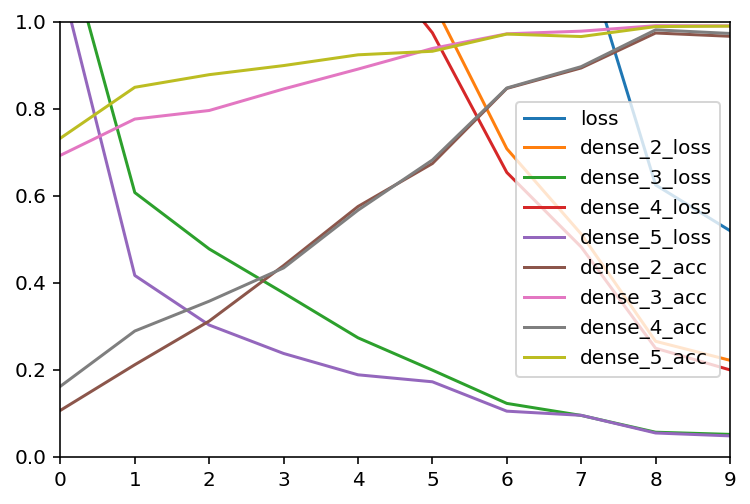

In [47]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [0]:
# Load / save

In [48]:
model_name = "Piano_2h.h5"
model.save(model_name)
#model = load_model(model_name)

In [49]:
# Build seed
idx = 420
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in range(tracks)]

for track in range(tracks):
    for i in range(seq_len):
        str_note = notes_vocab[track][np.argmax(x_test[2*track][i])]
        duration = durations_vocab[track][np.argmax(x_test[2*track+1][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [50]:
# make seq_len predictions from seed
preds = [[] for track in range(tracks)]
x = x_test

for _ in range(seq_len):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 2)]
    _duration = [pred[i] for i in range(1, len(pred), 2)]
    for track in range(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        x[2*track] = x[2*track][1:]
        x[2*track] = list(x[2*track]) + [cat_note]
        x[2*track+1] = x[2*track+1][1:]
        x[2*track+1] = list(x[2*track+1]) + [cat_duration]
        preds[track].append((cat_note, cat_duration))

In [51]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in range(tracks)]

for track in range(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [52]:
# play seed
x_full_score = stream.Score()
for track in range(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
#x_full_score.show()
x_full_score.chordify()
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [53]:
# play generated music
y_full_score = stream.Score()
for track in range(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
#y_full_score.show()
y_full_score.chordify()
y_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()